In [61]:
import os
import sys
import numpy as np
import skimage
import skimage.measure
import skimage.morphology
import glob
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from scipy import ndimage
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
sys.path.append('/home/kumarv/khand035/.conda/envs/gdalenv/lib/python2.7/site-packages/')
from osgeo import gdal,ogr

def RecoverLabels(pmasks,masks,emask):
    rows,cols,numt = masks.shape
   
    for i in range(0,numt):
        cur_mask = masks[:,:,i].copy()
        cur_pmask = pmasks[:,:,i].copy()
        cur_pmask[emask] = cur_mask[emask]
        pmasks[:,:,i] = cur_pmask

    return pmasks

def SelectLargestComponent(masks,jrc_mask):
    rows,cols,numt = masks.shape
    new_masks = np.zeros((rows,cols,numt))
    
    for i in range(0,numt):
        cur_mask = masks[:,:,i]==1
        cur_labels = skimage.measure.label(cur_mask,background=0)
        cur_labels_count = cur_labels.copy()
        cur_labels_count[jrc_mask<5] = 0
#         if i ==0:
#             f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True,figsize=(15,10))
#             ax1.imshow(cur_mask)
#             ax2.imshow(cur_labels)
            
#             temp = np.bincount(cur_labels.flatten())
#             print temp
        
        if np.max(cur_labels)==0 or np.max(cur_labels_count)==0:
            lcc=-2
        else:
            lcc = np.argmax(np.bincount(cur_labels_count.flatten())[1:])
        
        new_mask = cur_labels==lcc+1
        new_mask = new_mask.astype('int')
        new_mask[masks[:,:,i]>1] = 2
        new_masks[:,:,i] = new_mask
        
    return new_masks

def pix2coord(x,y,image):
    ds = gdal.Open(image,0)
    # GDAL affine transform parameters, According to gdal documentation xoff/yoff are image left corner, a/e are pixel wight/height and b/d is rotation and is zero if image is north up. 
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    """Returns global coordinates from pixel x, y coords"""
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)


def PrepareCrossSections2(image,geobase):
    sr = 5 # start row
    jump = 3
    sw = 3 # section winow width
    nc = 7
    row1, col1 = image.shape
    linds = np.where(image==1)
    rinds = linds[0]
    cinds = linds[1]
    sinds = np.lexsort((rinds,cinds))
    rinds = rinds[sinds]
    cinds = cinds[sinds]
    pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
    drange = np.max([(np.max(rinds) - np.min(rinds))*1.0/(nc+1),(np.max(cinds) - np.min(cinds))*1.0/(nc+1)])
    cross_image = np.zeros((row1,col1,nc)) # store each cross section separately
    coord_info = np.zeros((nc,2)) # store each cross section separately
    ctr = 0
    for i in range(0,nc):
        cur_image = np.zeros((row1,col1))
        cur_dist = np.min(pdist) + i*drange
        cur_diff = np.abs(pdist - cur_dist)
        p = np.argmin(cur_diff)
        p = int(drange+i*drange)
        i = rinds[p]
        j = cinds[p]
        clat,clon = pix2coord(i,j,geobase)
        cur_image[i-sw:i+sw,j-sw:j+sw] = image[i-sw:i+sw,j-sw:j+sw]
        # i,j is the pixel through which cross section should pass
        
        h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):

            if angle>np.pi/2:
                angle = angle - np.pi/2
            else:
                angle = angle + np.pi/2

            dist = j*np.cos(angle)*1.0 + i*np.sin(angle)*1.0


            lin_image = np.zeros((row1,col1))
            # burning the line
            klist = np.arange(0,col1,0.1)
            for k in klist:
                y1 = (dist - k * np.cos(angle)) / np.sin(angle)
                y1_int = int(np.round(y1))
                k_int = int(np.round(k))
                if y1_int>=0 and y1_int<row1 and k_int>=0 and k_int<col1:
                    lin_image[y1_int,k_int] = 1
            
            # use the cross section if it passes the current center line pixel
            # exit after finding the first such cross section
            if lin_image[i,j]>0:
                lin_image = skimage.morphology.skeletonize(lin_image)
                cross_image[:,:,ctr] = lin_image
                coord_info[ctr,0] = clat
                coord_info[ctr,1] = clon
                ctr = ctr + 1
                break

    return cross_image,coord_info
                
'''
    pargs = np.argsort(pdist)
    
    temp = np.arange(sr,pargs.shape[0],jump)
    cross_image = np.zeros((row1,col1,temp.shape[0])) # store each cross section separately
    coord_info = np.zeros((temp.shape[0],2)) # store each cross section separately
    
    ctr = 0
    for p in range(sr,pargs.shape[0],jump):
        cur_image = np.zeros((row1,col1))
        i = rinds[pargs[p]]
        j = cinds[pargs[p]]
        clat,clon = pix2coord(i,j,geobase)
        cur_image[i-sw:i+sw,j-sw:j+sw] = image[i-sw:i+sw,j-sw:j+sw]
        # i,j is the pixel through which cross section should pass
        
        h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):

            if angle>np.pi/2:
                angle = angle - np.pi/2
            else:
                angle = angle + np.pi/2

            dist = j*np.cos(angle)*1.0 + i*np.sin(angle)*1.0


            lin_image = np.zeros((row1,col1))
            # burning the line
            klist = np.arange(0,col1,0.1)
            for k in klist:
                y1 = (dist - k * np.cos(angle)) / np.sin(angle)
                y1_int = int(np.round(y1))
                k_int = int(np.round(k))
                if y1_int>=0 and y1_int<row1 and k_int>=0 and k_int<col1:
                    lin_image[y1_int,k_int] = 1
            
            # use the cross section if it passes the current center line pixel
            # exit after finding the first such cross section
            if lin_image[i,j]>0:
                lin_image = skimage.morphology.skeletonize(lin_image)
                cross_image[:,:,ctr] = lin_image
                coord_info[ctr,0] = clat
                coord_info[ctr,1] = clon
                ctr = ctr + 1
                break
'''    
def PrepareCrossSections3(image,geobase):
    sr = 5 # start row
    jump = 3
    sw = 3 # section winow width
    nc = 5
    row1, col1 = image.shape
    linds = np.where(image==1)
    rinds = linds[0]
    cinds = linds[1]
    sinds = np.lexsort((rinds,cinds))
    rinds = rinds[sinds]
    cinds = cinds[sinds]
    if rinds.shape[0]==0:
        cross_image = np.zeros((row1,col1,nc)) # store each cross section separately
        coord_info = np.zeros((nc,2)) # store each cross section separately
        return cross_image, coord_info
    
    if (np.max(rinds) - np.min(rinds)) > np.max(cinds) - np.min(cinds):
        pdist = rinds
        drange = row1*1.0/(nc+1)
    else:
        pdist = cinds
        drange = col1*1.0/(nc+1)
    
    cross_image = np.zeros((row1,col1,nc)) # store each cross section separately
    coord_info = np.zeros((nc,2)) # store each cross section separately
    ctr = 0
    plist = []
    for i in range(0,nc):
        cur_image = np.zeros((row1,col1))
        cur_dist = drange + i*drange
        cur_diff = np.abs(pdist - cur_dist)
        p = np.argmin(cur_diff)
        if p in plist:
            continue
        plist.append(p)
        #p = int(drange+i*drange)
        i = rinds[p]
        j = cinds[p]
        clat,clon = pix2coord(i,j,geobase)
        cur_image[i-sw:i+sw,j-sw:j+sw] = image[i-sw:i+sw,j-sw:j+sw]
        # i,j is the pixel through which cross section should pass
        
        h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):

            if angle>np.pi/2:
                angle = angle - np.pi/2
            else:
                angle = angle + np.pi/2

            dist = j*np.cos(angle)*1.0 + i*np.sin(angle)*1.0


            lin_image = np.zeros((row1,col1))
            # burning the line
            klist = np.arange(0,col1,0.1)
            for k in klist:
                y1 = (dist - k * np.cos(angle)) / np.sin(angle)
                y1_int = int(np.round(y1))
                k_int = int(np.round(k))
                if y1_int>=0 and y1_int<row1 and k_int>=0 and k_int<col1:
                    lin_image[y1_int,k_int] = 1
            
            # use the cross section if it passes the current center line pixel
            # exit after finding the first such cross section
            if lin_image[i,j]>0:
                lin_image = skimage.morphology.skeletonize(lin_image)
                cross_image[:,:,ctr] = lin_image
                coord_info[ctr,0] = clat
                coord_info[ctr,1] = clon
                ctr = ctr + 1
                break

    return cross_image,coord_info

def GetCrossSectionProfiles(csec,cline,lmask,delv):
    linds = np.where(csec==1)
    rinds = linds[0]
    cinds = linds[1]
    pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
    
    pargs = np.argsort(pdist)
    
    temp = np.arange(0,pargs.shape[0])
    labp = np.zeros((temp.shape[0],))
    elep = np.zeros((temp.shape[0],))
    ctr = 0
    for p in range(0,temp.shape[0]):
        i = rinds[pargs[p]]
        j = cinds[pargs[p]]
        labp[p] = lmask[i,j]
        elep[p] = delv[i,j]
        if cline[i,j]==1:
            cp = p
            
        
    return labp,elep,cp

def GetCrossSectionProfiles2(csec,cline,lmask,delv):
    row,cols = csec.shape
    
    csec = csec.flatten()
    cline = cline.flatten()
    lmask = lmask.flatten()
    delv = delv.flatten()
    
    linds = np.where(csec==1)[0]
    #print linds
    temp = np.zeros((row*cols,))
    temp[linds] = 1
    temp = np.reshape(temp,(row,cols))
    #plt.figure()
    #plt.imshow(temp)
    
    temp = np.arange(0,linds.shape[0])
    labp = np.zeros((linds.shape[0],))
    elep = np.zeros((linds.shape[0],))
    ctr = 0
    for p in range(0,linds.shape[0]):
        labp[p] = lmask[linds[p]]
        elep[p] = delv[linds[p]]
        if cline[linds[p]]==1:
            cp = p
        
    return labp,elep,cp


def GetCrossSectionProfiles3(csec,cline,lmask,delv):
    row,cols = csec.shape
    linds = np.where(csec==1)
    rinds = linds[0]
    cinds = linds[1]
#     print rinds
#     print cinds
    if np.max(rinds) - np.min(rinds)>np.max(cinds) - np.min(cinds):
        sinds = np.lexsort((row-rinds,cinds))
    else:
        sinds = np.lexsort((row-rinds,cinds))
    
    labp = np.zeros((rinds.shape[0],))
    elep = np.zeros((rinds.shape[0],))
    rmask = np.zeros((row,cols))
    ctr = 0
    for p in range(0,rinds.shape[0]):
        labp[p] = lmask[rinds[sinds[p]],cinds[sinds[p]]]
        elep[p] = delv[rinds[sinds[p]],cinds[sinds[p]]]
        rmask[rinds[sinds[p]],cinds[sinds[p]]] = p+1
        if cline[rinds[sinds[p]],cinds[sinds[p]]]==1:
            cp = p
        
    return labp,elep,cp,rmask

def GetCrossSectionProfiles4(csec,cline,lmask,delv):
    row,cols = csec.shape
    linds = np.where(csec==1)
    rinds = linds[0]
    cinds = linds[1]
    sinds = np.argsort(np.minimum(cinds,rinds))
    curr = rinds[sinds[0]]
    curc = cinds[sinds[0]]
    sinds = sinds.astype(int)
    sinds[1:] = -1
    bad_inds = np.zeros((rinds.shape[0],)).astype(int)
    bad_inds[sinds[0]] = 1
    #print sinds[0],curr,curc,bad_inds[sinds[0]]
    for i in range(1,rinds.shape[0]):
        
        cur_diff = np.abs(rinds-curr) + np.abs(cinds-curc)
        cur_diff[bad_inds==1] = np.max(cur_diff)+1
        
        sinds[i] = int(np.argmin(cur_diff))
        bad_inds[sinds[i]] = 1
        #print bad_inds
        curr = rinds[sinds[i]]
        curc = cinds[sinds[i]]
        #print sinds[i],curr,curc,bad_inds[sinds[i]]
    #print sinds
    #print rinds
    #print sinds
#     print rinds
#     print cinds
#     if np.max(rinds) - np.min(rinds)>np.max(cinds) - np.min(cinds):
#         sinds = np.lexsort((row-rinds,cinds))
#     else:
#         sinds = np.lexsort((row-rinds,cinds))
    
    labp = np.zeros((rinds.shape[0],))
    elep = np.zeros((rinds.shape[0],))
    rmask = np.zeros((row,cols))
    ctr = 0
    for p in range(0,rinds.shape[0]):
        labp[p] = lmask[rinds[sinds[p]],cinds[sinds[p]]]
        elep[p] = delv[rinds[sinds[p]],cinds[sinds[p]]]
        rmask[rinds[sinds[p]],cinds[sinds[p]]] = p+1
        if cline[rinds[sinds[p]],cinds[sinds[p]]]==1:
            cp = p
        
    return labp,elep,cp,rmask



def SelectMaximumExtent(frac,pmasks):
    score = np.zeros((pmasks.shape[2],))
    for i in range(0,pmasks.shape[2]):
        score[i] = np.sum(frac!=pmasks[:,:,i])
    return np.argmin(score)

def FitLine(x,y,tx):
    m = (y[1]-y[0])*1.0/(x[1]-x[0])
    c = y[0] - m*x[0]
    ty = np.zeros((len(tx),))
    for i in range(0,len(tx)):
        ty[i] = m*tx[i] + c
    return ty

def IterativeConvolution(elvp,sw):
    elvp_arr = []
    while(sw>0):
        temp = np.convolve(elvp, np.ones((sw,))/sw, mode='same')
        temp[0:sw/2] = -1
        temp[-sw/2:] = -1
        elvp_arr.append(temp)
        sw = sw/2
    elvp_arr.append(elvp)
    felvp = elvp.copy()
    felvp[:] = -1
    ctr = 0
    while np.sum(felvp==-1)>0:
        cur_elvp = elvp_arr[ctr]
        need_inds = felvp==-1
        felvp[need_inds] = cur_elvp[need_inds]
        ctr = ctr+1
    return felvp

        
    
    

In [57]:
data_dir = '/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/'
flag = 0
mask_list = glob.glob(data_dir + 'F*.tif')
mask_list.sort()
datestr_list = []
datetim_list = []
datefmt_list = []

%matplotlib inline
for filename in mask_list:
    print filename
    u1 = filename.find('_')
    u2 = filename.rfind('.')
    datestr = filename[u1+1:u2]
    #datefmt = datestr[0:4] + '-' + datestr[4:6] + '-' + datestr[6:8] + 'T' + datestr[9:11] + ':' + datestr[11:13] + ':' + datestr[13:15]
    datefmt = datestr[0:4] + '-' + datestr[4:6] + '-' + datestr[6:8] + 'T' + '00' + ':' + '00' + ':' + '00'
    #print datefmt
    datenum = datetime.strptime(datefmt, '%Y-%m-%dT%H:%M:%S')
    datestr_list.append(datestr)
    datetim_list.append((datenum - datetime(1970,1,1)).days)
    datefmt_list.append(datefmt)
    ds = gdal.Open(filename)
    numchannels = ds.RasterCount
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    mask_arr = np.array(ds.GetRasterBand(1).ReadAsArray())
    if flag==0:
        masks = np.zeros((rows,cols,len(mask_list)))
    masks[:,:,flag] = mask_arr
    flag = flag + 1



/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160120.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160121.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160128.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160130.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160209.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160219.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160310.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160320.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160330.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_20160409.tif
/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2105-75/F3_2

In [51]:
temp = glob.glob(data_dir + 'F*.tif')
temp2 = np.lexsort((temp))
print temp2

0


In [62]:
ds = gdal.Open(data_dir + 'dem.tiff')
delv = np.array(ds.GetRasterBand(1).ReadAsArray())
ds = gdal.Open(data_dir + 'jrc.tiff')
djrc = np.array(ds.GetRasterBand(1).ReadAsArray())
pmasks = SelectLargestComponent(masks,djrc)
nmask = np.sum(pmasks==1,axis=2)*1.0
dmask = np.sum(pmasks<=1,axis=2)*1.0
eth = 0.3
emask = np.divide(nmask,dmask)>eth
pmasks = RecoverLabels(pmasks,masks,emask)
max_extent_ind = SelectMaximumExtent(np.divide(nmask,dmask)>0.1,pmasks)
# sdateinds = np.lexsort(datestr_list)


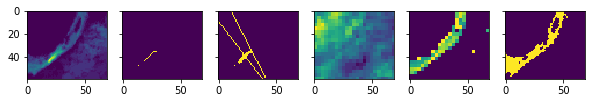

In [63]:
# emask = pmasks[:,:,22]
emask = ndimage.binary_fill_holes(emask)
cline = skimage.morphology.skeletonize(emask)
csecs,ccord = PrepareCrossSections3(cline,data_dir + 'dem.tiff')
f, (ax1, ax2, ax3, ax4,ax5,ax6) = plt.subplots(1,6, sharex=True, sharey=True,figsize=(10,5))
ax1.imshow(np.divide(nmask,dmask))
ax2.imshow(cline)
temp = emask.copy()
temp[np.sum(csecs[:,:,0:],axis=2)>0] = 2
ax3.imshow(temp)
ax4.imshow(delv)
ax5.imshow(djrc)
ax6.imshow(pmasks[:,:,max_extent_ind])
plt.show()



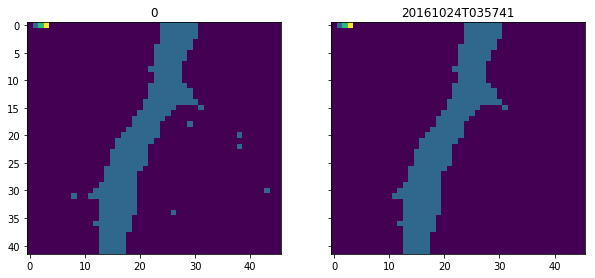

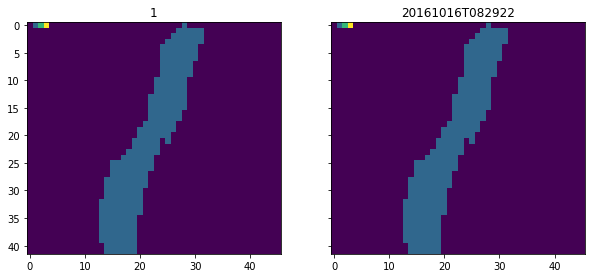

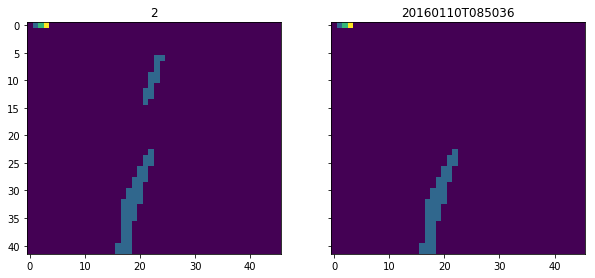

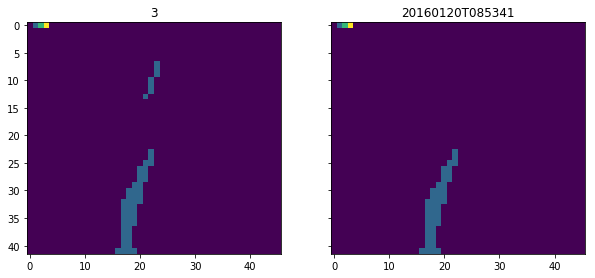

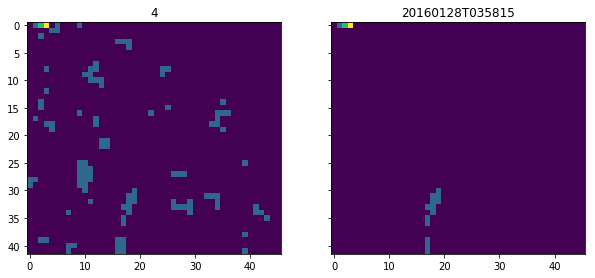

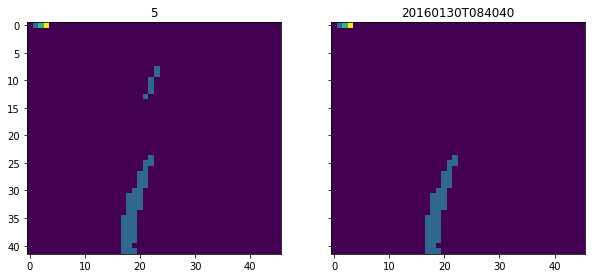

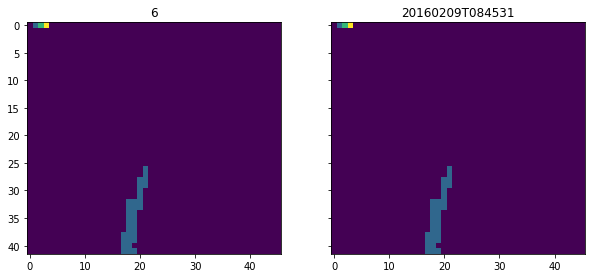

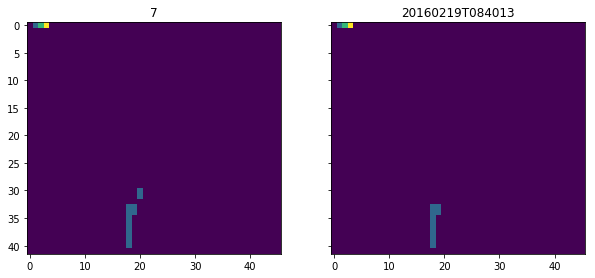

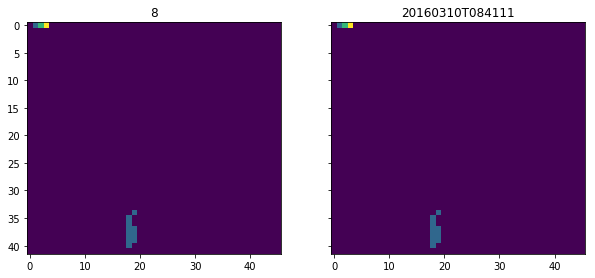

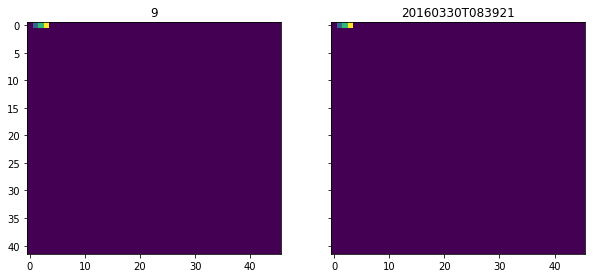

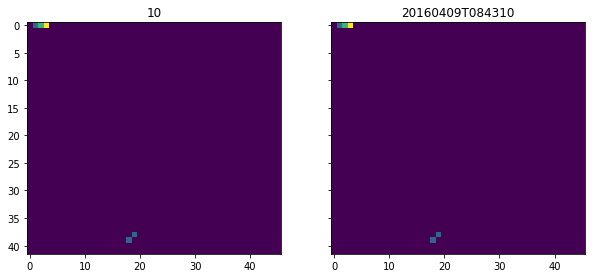

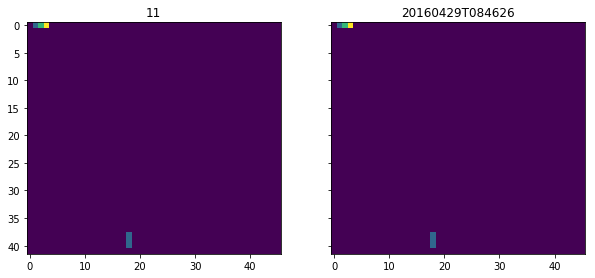

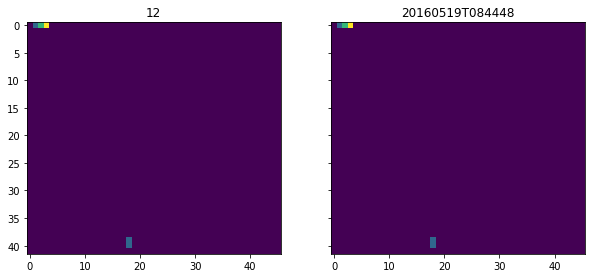

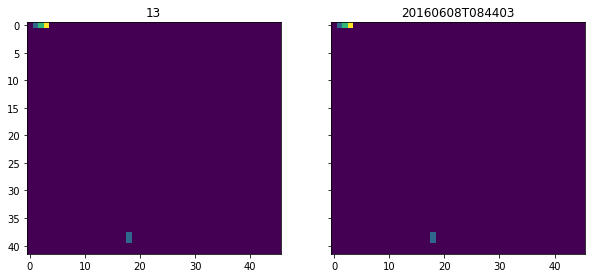

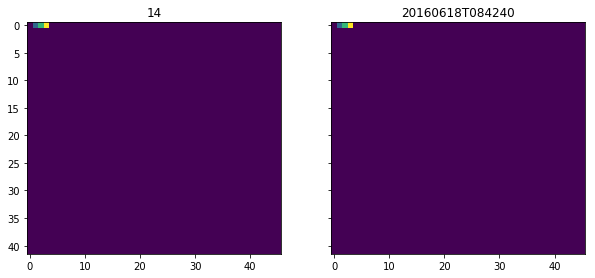

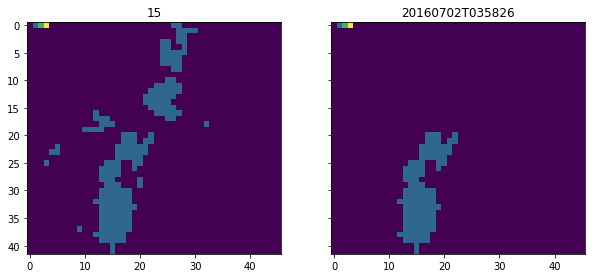

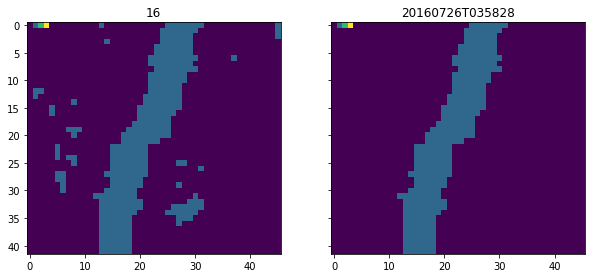

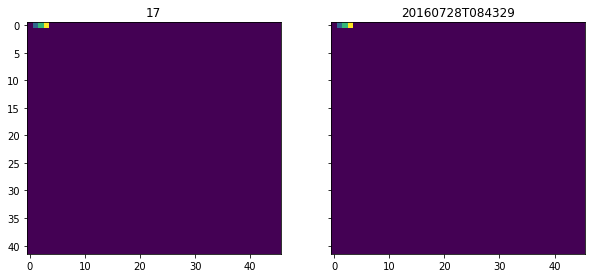

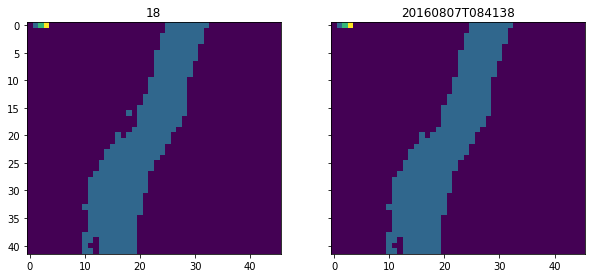

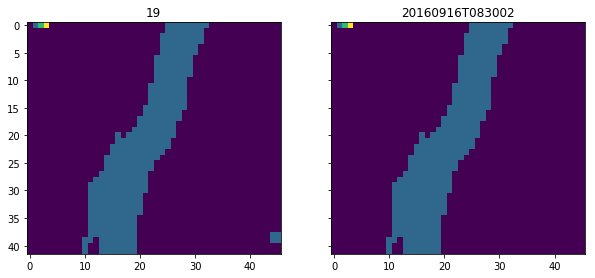

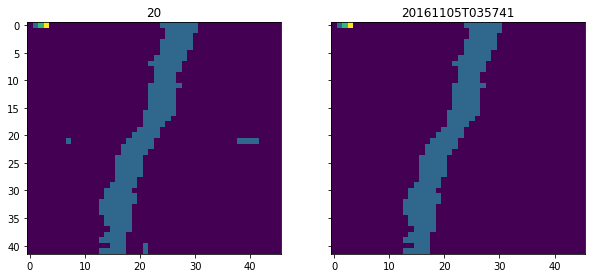

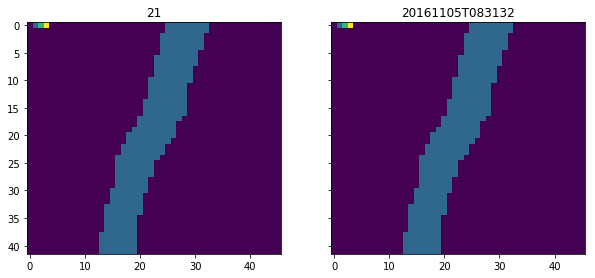

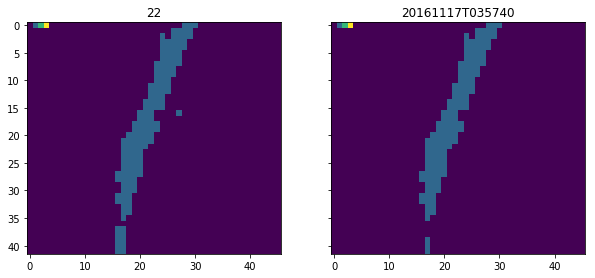

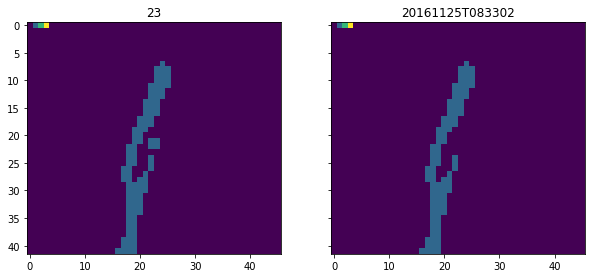

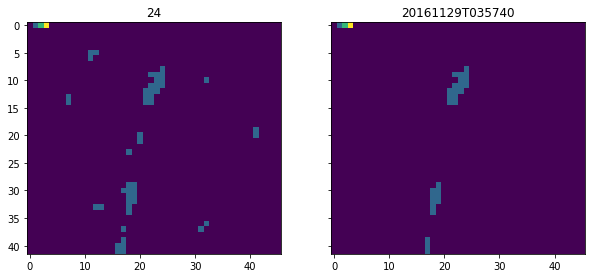

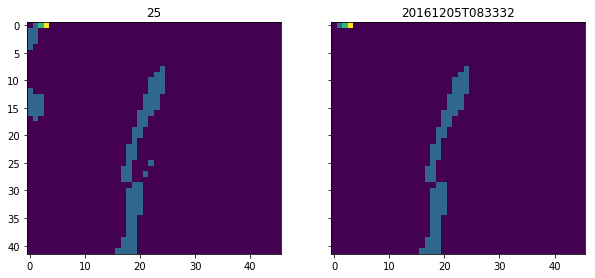

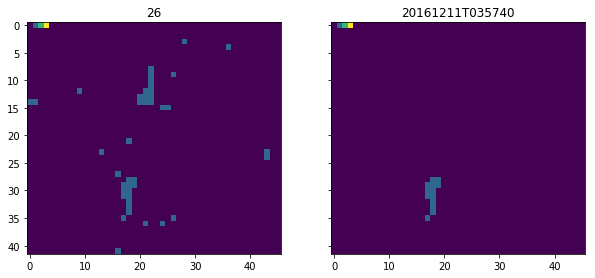

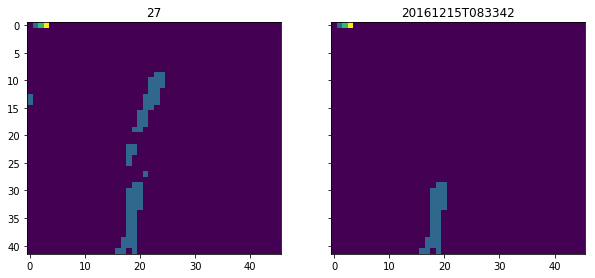

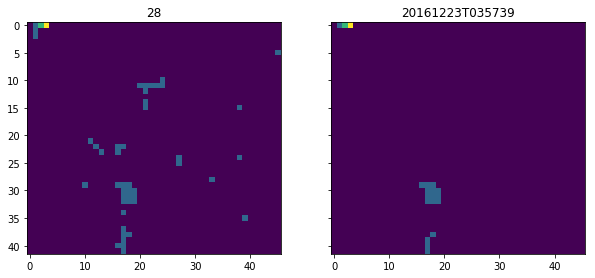

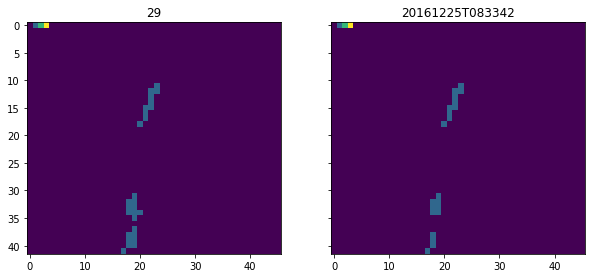

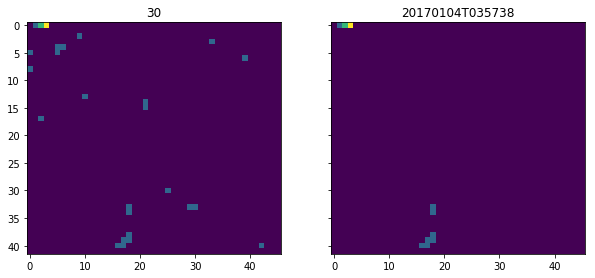

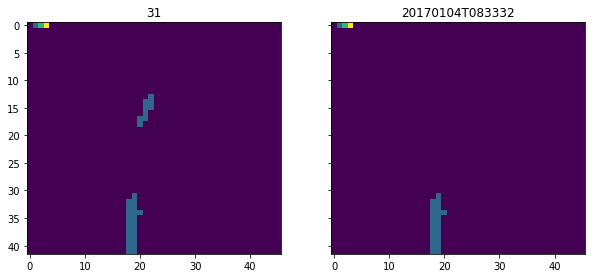

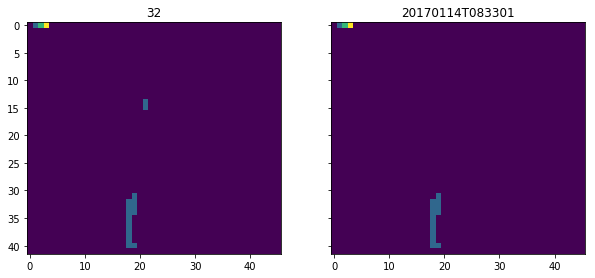

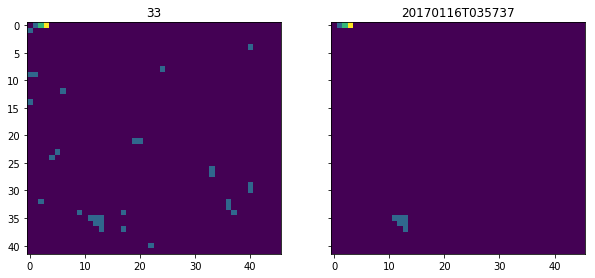

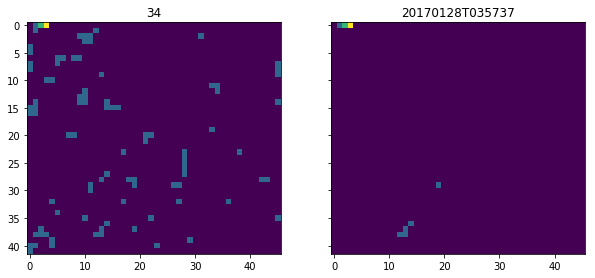

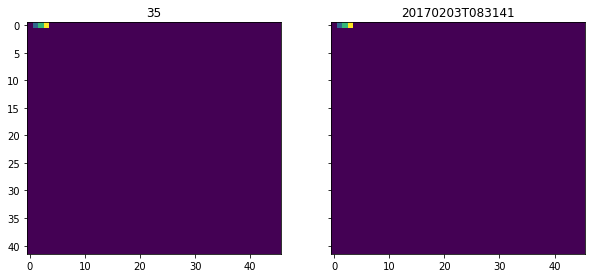

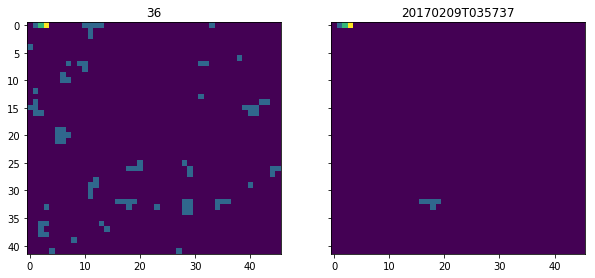

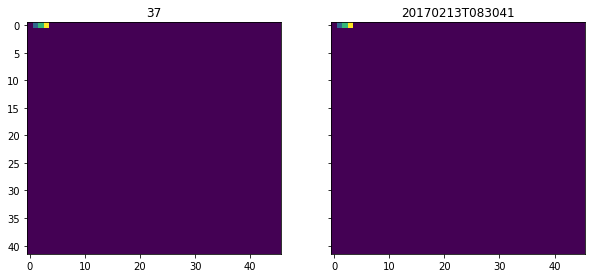

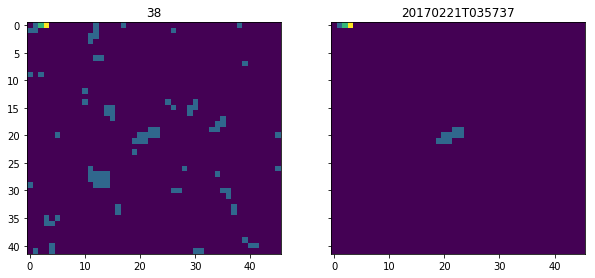

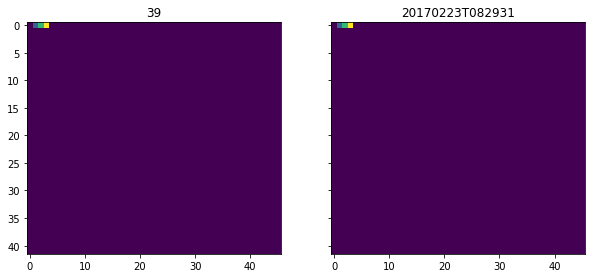

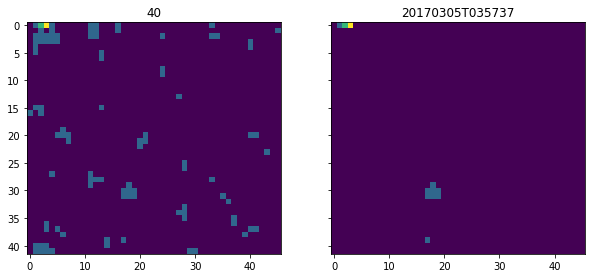

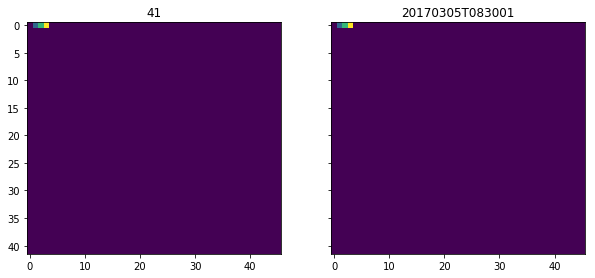

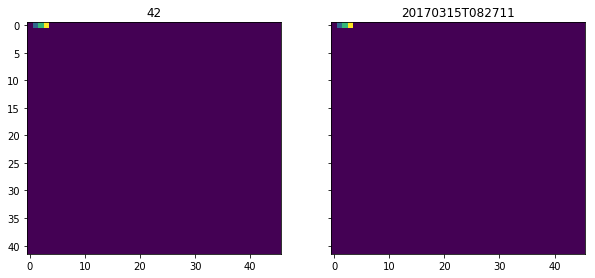

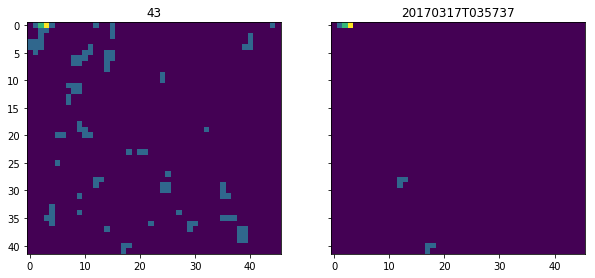

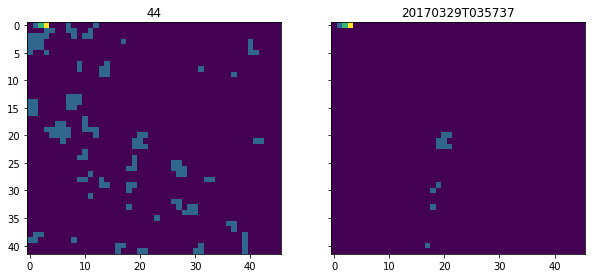

In [45]:
bad_inds = []
for i in range(0,pmasks.shape[2]):
        
        cur_mask = masks[:,:,i].copy()
        cur_pmask = pmasks[:,:,i].copy()
        if np.sum(cur_mask>1)*1.0/(cur_mask.shape[0]*cur_mask.shape[1])>0:
            bad_inds.append(i)
            continue
        f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True,figsize=(10,5))
        cur_mask[0,0] = 0
        cur_mask[0,1] = 1
        cur_mask[0,2] = 2
        cur_mask[0,3] = 3
        
        cur_pmask[0,0] = 0
        cur_pmask[0,1] = 1
        cur_pmask[0,2] = 2
        cur_pmask[0,3] = 3
        
        ax1.imshow(cur_mask)
        ax1.set_title(str(i))
        ax2.imshow(cur_pmask)
        ax2.set_title(datestr_list[i])

        


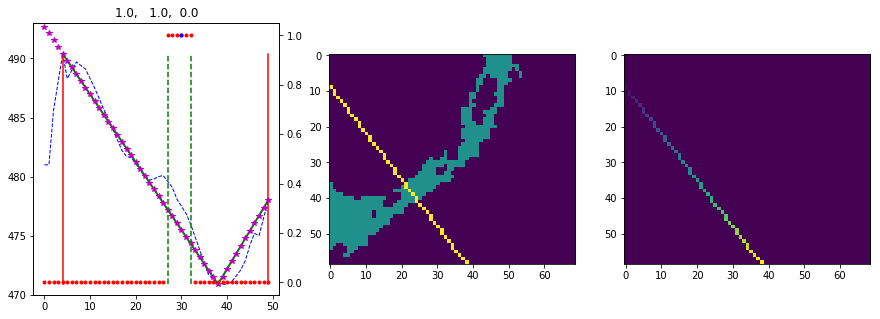

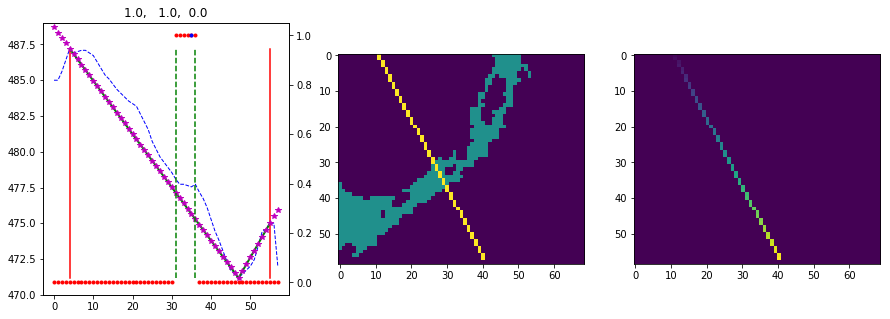

In [64]:
%matplotlib inline
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
elvp_arr = []
cls_min_arr = []
lml_ind_arr = []
lmr_ind_arr = []

for j in range(0,csecs.shape[2]):
    cur_mask = pmasks[:,:,max_extent_ind].copy()
    cur_sec = csecs[:,:,j].copy()
    if np.sum(cur_sec)==0:
        continue
        
    labp,elvp,cp,rmask = GetCrossSectionProfiles4(cur_sec,cline,cur_mask,delv)
    elvp_org = elvp.copy()
    sw = np.min([20,int(len(labp)*0.2)])
    emin = np.min(elvp)
    emax = np.max(elvp)
    elvp = IterativeConvolution(elvp,sw)
#     elvp = np.convolve(elvp, np.ones((sw,))/sw, mode='same')
#     elvp[0:sw/2] = elvp_org[0:sw/2]
#     elvp[-sw/2:] = elvp_org[-sw/2:]
    ielvp = elvp.copy()
    max_inds = argrelextrema(elvp, np.greater_equal,order=5)[0]
    min_inds = argrelextrema(elvp, np.less_equal,order=5)[0]
    
   
    
#     # Method - 1 
#     cur_dif = np.abs(min_inds - cp)
#     cls_min = np.argmin(cur_dif)
#     cur_dif = max_inds - min_inds[cls_min]
#     cur_dif[cur_dif>0] = np.min(cur_dif)-1
#     lml_ind = np.argmax(cur_dif)
#     cur_dif = max_inds - min_inds[cls_min]
#     cur_dif[cur_dif<0] = np.max(cur_dif)+1
#     lmr_ind = np.argmin(cur_dif)
    
#     ax1.plot([max_inds[lml_ind], max_inds[lml_ind]],[np.min(elvp),np.max(elvp)],'-r')
#     ax1.plot([max_inds[lmr_ind], max_inds[lmr_ind]],[np.min(elvp),np.max(elvp)],'-r')
#     ax1.plot([min_inds[cls_min], min_inds[cls_min]],[np.min(elvp),np.max(elvp)],'-k')
    
    
    # Method - 2
    score = np.zeros((len(min_inds),))
    lscore = np.zeros((len(min_inds),))
    rscore = np.zeros((len(min_inds),))
    for cls_min in range(0,len(min_inds)):
        
        cur_dif = max_inds - min_inds[cls_min]
        cur_dif[cur_dif>0] = np.min(cur_dif)-1
        lml_ind = np.argmax(cur_dif)
        cur_dif = max_inds - min_inds[cls_min]
        cur_dif[cur_dif<0] = np.max(cur_dif)+1
        lmr_ind = np.argmin(cur_dif)
        score[cls_min] = np.sum(labp[max_inds[lml_ind]:max_inds[lmr_ind]]==1)*1.0/np.sum(labp==1)
        lscore[cls_min] = np.sum(labp[max_inds[lml_ind]:min_inds[cls_min]]==1)*1.0/np.sum(labp==1)
        rscore[cls_min] = np.sum(labp[min_inds[cls_min]:max_inds[lmr_ind]]==1)*1.0/np.sum(labp==1)
    
    cls_min = np.lexsort((-1*np.abs(min_inds-cp),score))[-1]
    
    #if score[cls_min]<0.9 or lscore[cls_min] <0.3 or rscore[cls_min]<0.3:
    #    a = 1
    #else:
    #    continue
    fig, (ax1,ax3,ax4) = plt.subplots(1,3,figsize=(15,5))
    ax1.plot(elvp,'--b',linewidth=1)
    ax1.set_ylim([emin,emax])
    ax2 = ax1.twinx()
    ax2.plot(labp,'r.')
    ax2.plot(cp,1,'b.')       
    cur_dif = max_inds - min_inds[cls_min]
    cur_dif[cur_dif>0] = np.min(cur_dif)-1
    lml_ind = np.argmax(cur_dif)
    cur_dif = max_inds - min_inds[cls_min]
    cur_dif[cur_dif<0] = np.max(cur_dif)+1
    lmr_ind = np.argmin(cur_dif)
    
    
    lx = [max_inds[lml_ind],min_inds[cls_min]]
    ly = [elvp[max_inds[lml_ind]],elvp[min_inds[cls_min]]]
    rx = [max_inds[lmr_ind],min_inds[cls_min]]
    ry = [elvp[max_inds[lmr_ind]],elvp[min_inds[cls_min]]]
    tlx = np.arange(0,min_inds[cls_min])
    trx = np.arange(min_inds[cls_min],len(ielvp))
    
    ielvp[tlx] = FitLine(lx,ly,tlx)
    ielvp[trx] = FitLine(rx,ry,trx)
    #print len(elvp), len(ielvp)
    
    wts_inds = np.where(labp==1)[0]
    cur_dif = wts_inds - max_inds[lml_ind]
    cur_dif[wts_inds<max_inds[lml_ind]] = np.max(cur_dif)+1
    ledge = wts_inds[np.argmin(cur_dif)]

    cur_dif = max_inds[lmr_ind] - wts_inds
    cur_dif[wts_inds>max_inds[lmr_ind]] = np.max(cur_dif)+1
    redge = wts_inds[np.argmin(cur_dif)]
    #print ledge,redge
    
    cls_min_arr.append(min_inds[cls_min])
    lmr_ind_arr.append(max_inds[lmr_ind])
    lml_ind_arr.append(max_inds[lml_ind])
    elvp_arr.append(ielvp)
    
    
    
    ax1.plot([max_inds[lml_ind], max_inds[lml_ind]],[np.min(elvp),np.max(elvp)],'-r')
    ax1.plot([max_inds[lmr_ind], max_inds[lmr_ind]],[np.min(elvp),np.max(elvp)],'-r')
#     ax1.plot([min_inds[cls_min], min_inds[cls_min]],[np.min(elvp),np.max(elvp)],'-k')
    ax1.set_title(str(round(score[cls_min],2)) + ',   ' + str(round(lscore[cls_min],2)) + ',  ' + str(round(rscore[cls_min],2)))
    ax1.plot([min_inds[cls_min], max_inds[lml_ind]],[elvp[min_inds[cls_min]],elvp[max_inds[lml_ind]]],'-g',linewidth=2)
    ax1.plot([min_inds[cls_min], max_inds[lmr_ind]],[elvp[min_inds[cls_min]],elvp[max_inds[lmr_ind]]],'-g',linewidth=2)
    ax1.plot(ielvp,'*m',linewidth=5)
    ax1.plot([ledge,ledge],[np.min(elvp),np.max(elvp)],'--g')
    ax1.plot([redge,redge],[np.min(elvp),np.max(elvp)],'--g')
    
#     #print max_inds
#     #print min_inds
#     tvlp = elvp.copy()
#     tvlp[labp==0] = np.max(elvp)+1
#     min_ind = np.argmin(tvlp)
#     tvlp = elvp.copy()
#     tvlp[0:min_ind] = 0
#     tvlp[labp==0] = 0
#     rmax_ind = np.where(labp==1)[0][-1]#np.argmax(tvlp)

#     tvlp = elvp.copy()
#     tvlp[min_ind:] = 0
#     tvlp[labp==0] = 0
#     lmax_ind = np.where(labp==1)[0][0] #np.argmax(tvlp)
# #     if min_ind - lmax_ind<1 or rmax_ind-min_ind<1:
# #         continue
        

    
#     ax1.plot(elvp,'.-b',linewidth=3)
#     for l in range(0,len(max_inds)):
#         if max_inds[l]>=lmax_ind and max_inds[l]<=rmax_ind:
#             ax1.plot([max_inds[l], max_inds[l]],[np.min(elvp),np.max(elvp)],'-r')
        
#     dmax_inds = max_inds - lmax_ind
#     dmax_inds[max_inds>lmax_ind] = np.min(dmax_inds)-1
#     temp = np.argmax(dmax_inds)
#     ax1.plot([max_inds[temp], max_inds[temp]],[np.min(elvp),np.max(elvp)],'-r')
        
#     dmax_inds = max_inds - rmax_ind
#     #print dmax_inds
#     dmax_inds[max_inds<rmax_ind] = np.max(dmax_inds)+1
#     temp = np.argmin(dmax_inds)
#     ax1.plot([max_inds[temp], max_inds[temp]],[np.min(elvp),np.max(elvp)],'-r')
        
    
#     for l in range(0,len(min_inds)):
#         if min_inds[l]>=lmax_ind and min_inds[l]<=rmax_ind:
#             ax1.plot([min_inds[l], min_inds[l]],[np.min(elvp),np.max(elvp)],'-k')  
    
# #     ax1.plot([min_ind, min_ind],[np.min(elvp),np.max(elvp)],'-k')
#     ax1.plot([lmax_ind, lmax_ind],[np.min(elvp),np.max(elvp)],'--g')
#     ax1.plot([rmax_ind, rmax_ind],[np.min(elvp),np.max(elvp)],'--g')
# #     ax1.plot([rmax_ind, min_ind],[elvp[rmax_ind],elvp[min_ind]],'-g',linewidth=2)
# #     ax1.plot([lmax_ind, min_ind],[elvp[lmax_ind],elvp[min_ind]],'-g',linewidth=2)
# #     ax1.plot([lmax_ind, rmax_ind],[np.min([elvp[lmax_ind],elvp[rmax_ind]]),np.min([elvp[lmax_ind],elvp[rmax_ind]])],'-g',linewidth=2)
    
    
    
    
    ax3.plot()
#     plt.title(str(min_ind-lmax_ind) + ',' + str(rmax_ind-min_ind))

#     f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10,5))
    cur_mask[cur_sec==1] = 2
#     ax1.imshow(cur_sec)
#     ax2.imshow(cline)
    ax3.imshow(cur_mask)
    ax4.imshow(rmask)
    plt.show()




20160120
20170329
20160120
20170329
20160120
20170329
20160120
20170329
20160120
20170329


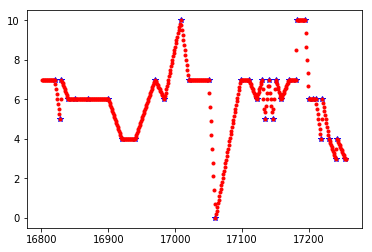

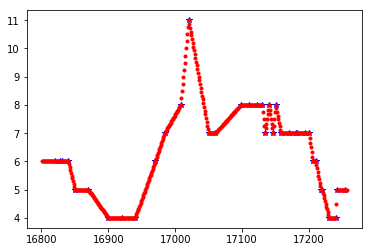

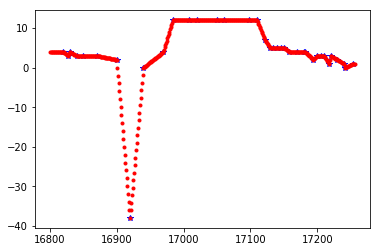

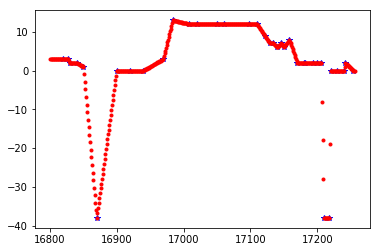

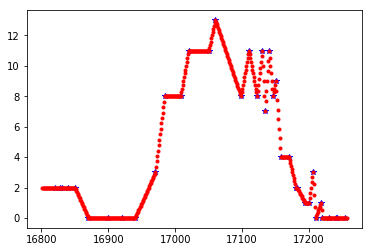

In [56]:
fid = open('test-timeseries.csv','w')

for c in range(0,csecs.shape[2]):
    #print c
    fid2 = open('test-caliseries.csv','w')
    cur_sec = csecs[:,:,c].copy()
    cord = ccord[c]
    sdate = (datetime(2016,1,1) - datetime(1970,1,1)).days
    edate = (datetime(2017,3,31) - datetime(1970,1,1)).days
    wts_full = np.zeros((edate-sdate+1,))
    fullx = np.arange(sdate,edate+1)
    sind = np.where(fullx==datetim_list[0])[0][0]
    eind = np.where(fullx==datetim_list[-1])[0][0]
    print datestr_list[0]
    print datestr_list[-1]
    numt = pmasks.shape[2]
    wts = np.zeros((numt,))
    lml_ind = lml_ind_arr[c]
    lmr_ind = lmr_ind_arr[c]
    cls_min = cls_min_arr[c]
    ielvp = elvp_arr[c]
    for i in range(0,numt):
        #print c,i
        cur_mask = pmasks[:,:,i].copy()
        labp,elvp,cp = GetCrossSectionProfiles2(cur_sec,cline,cur_mask,delv)
        wts_inds = np.where(labp==1)[0]
        if wts_inds.shape[0]==0:
            fid2.write(datefmt_list[i] + ',' + str(0) + ',' + str(0) + ',' + str(0) + '\n')
            wts[i] = 0
        else:
            
        
            cur_dif = wts_inds - lml_ind
            pad_max = np.max(cur_dif)+1
            cur_dif[wts_inds<lml_ind] = pad_max 
            ledge = wts_inds[np.argmin(cur_dif)]
            if np.min(cur_dif)==pad_max:
                ledge=-1

            cur_dif = lmr_ind - wts_inds
            pad_max = np.max(cur_dif)+1
            cur_dif[wts_inds>lmr_ind] = pad_max
            redge = wts_inds[np.argmin(cur_dif)]
            if np.min(cur_dif)==pad_max:
                redge=-1

            #print wts_inds,ledge,redge
            if ledge>=0 and redge>=0:
                fid2.write(datefmt_list[i] + ',' + str(redge-ledge+1) + ',' + str(ielvp[ledge]-ielvp[cls_min]) + ',' + str(ielvp[redge]-ielvp[cls_min]) + '\n')
            else:
                fid2.write(datefmt_list[i] + ',' + str(0) + ',' + str(0) + ',' + str(0) + '\n')

            wts[i] = redge-ledge+1
    fid2.close()
    f = interp1d(datetim_list,wts,kind='linear')
    newx = np.arange(datetim_list[0],datetim_list[-1]+1)
    newy = f(newx)
    wts_full[0:sind] = wts[0]
    wts_full[eind:] = wts[-1]
    wts_full[sind:eind+1] = newy
    plt.figure()
    plt.plot(datetim_list,wts,'*b')
    plt.plot(fullx,wts_full,'.r')
    
    for i in range(0,len(wts_full)):
        new_date = datetime(1970,1,1) + timedelta(fullx[i])
        new_date_str = new_date.strftime('%Y-%m-%d')
        if fullx[i] in datetim_list:
            isorg = 1
        else:
            isorg = 0
        fid.write(new_date_str + ',' + str(round(wts_full[i],2)) + ',' + str(isorg) + ', POINT (' + str(cord[0]) + ' ' + str(cord[1]) + ') \n')
fid.close()

In [ ]:
'''
BIDS2100-1/ - cross sections have valleys but the extent does not match extactly with valleys. Show 
BIDS2100-53/ - there is one good cross section. Also has issue where cross section is touching the segment at multiple places
BIDS2100-54/ - there might be one cross section there that is useful. Show
BIDS2100-55/ - one good cross section. Show
BIDS2100-55/ - there is potentially one good one. Show
BIDS2101-3/ - has an example which needs some clarification. Show
'''